In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Pancreas
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Pancreas data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [2]:
# Directories
input_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/'
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/activation_model.xlsx' 
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Revision_1/Output/Pancreas/'

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'TM_pancreas.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 13774.40it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,pancreatic acinar cell,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637


## Dataset statistics

In [13]:
# Output dir for cell counts
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Revision_1/Output/'

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'stats_age'] = 'Young'

    else:                        
        barcode.loc[j, 'stats_age'] = 'Old'

In [9]:
# Change in cell names
barcode.cell_type.replace('type B pancreatic cell', 'pancreatic b_cell', inplace=True)
barcode.cell_type.replace('pancreatic A cell', 'pancreatic a_cell', inplace=True)
cells = ['pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic b_cell']
barcode.cell_type.unique()

['pancreatic b_cell', 'pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'pancreatic b_cell', 'pancreatic a_cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic PP cell', 'pancreatic stellate cell']

In [10]:
# Exploring cell counts
data = barcode[barcode['cell_type'].isin(cells)].value_counts(['cell_type', 'sex', 'stats_age', 'donor_id']).reset_index()
data.sort_values(by=['cell_type', 'sex', 'stats_age', 'donor_id'], 
                 ascending=[True, True, False, True], inplace=True)
data.reset_index(drop=True, inplace=True)
data.rename(columns={0: 'Counts'}, inplace=True)
data

,cell_type,sex,stats_age,donor_id,Counts
0,pancreatic b_cell,female,Young,3_38_F,139
1,pancreatic b_cell,female,Young,3_39_F,142
2,pancreatic b_cell,female,Old,18_47_F,142
3,pancreatic b_cell,male,Young,3_8_M,152
4,pancreatic b_cell,male,Young,3_10_M,89
5,pancreatic b_cell,male,Old,18_45_M,225
6,pancreatic b_cell,male,Old,24_60_M,253
7,pancreatic b_cell,male,Old,24_61_M,200
8,pancreatic a_cell,female,Young,3_38_F,98
9,pancreatic a_cell,female,Young,3_39_F,83


In [11]:
# Function to extract cell counts
def datastats(cellpop):
    celula = cellpop.split(' ')
    data2 = data[data.cell_type==cellpop]
    data2['Sex_age'] = data2['sex'].astype('str') + '_' + data2['stats_age'].astype('str')
    data2 = data2[['Sex_age', 'donor_id', 'Counts']]
    data2.sort_values(by=['Sex_age', 'donor_id', 'Counts'], ascending=[False, True, True],
                      inplace=True)
    custom_order = ['female_Young', 'female_Old', 'male_Young', 'male_Old']
    data2['Sex_age'] = pd.Categorical(data2['Sex_age'], categories=custom_order, ordered=True)

    data2 = data2.pivot_table(index='donor_id', columns='Sex_age', values='Counts', 
                              aggfunc='first')

    data2.reset_index(inplace=True)
    with pd.ExcelWriter(output_dir + "Cell_counts.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        data2.to_excel(writer, sheet_name=celula[1], index=True)

In [14]:
for i in cells:
    datastats(cellpop=i)

## CMA net score/cell type (fold over whole tissue)

In [5]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m


In [6]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m,-0.152319
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m,-0.067126
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m,0.117219
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m,-0.028869
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,normal,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m,-0.778264


In [8]:
barcode.cell_type.unique()

['type B pancreatic cell', 'pancreatic acinar cell', 'pancreatic A cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'leukocyte', 'pancreatic A cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic stellate cell', 'type B pancreatic cell']

In [8]:
cells = ['pancreatic acinar cell', 'pancreatic A cell', 'type B pancreatic cell']

## CMA net score/cell type & sex (fold over each cell type young)

In [7]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 46.38it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m,-0.152319,-0.199832
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m,-0.067126,-0.114639
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m,0.117219,0.069706
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m,-0.028869,-0.076382
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m,-0.778264,-0.351906


### Graphs

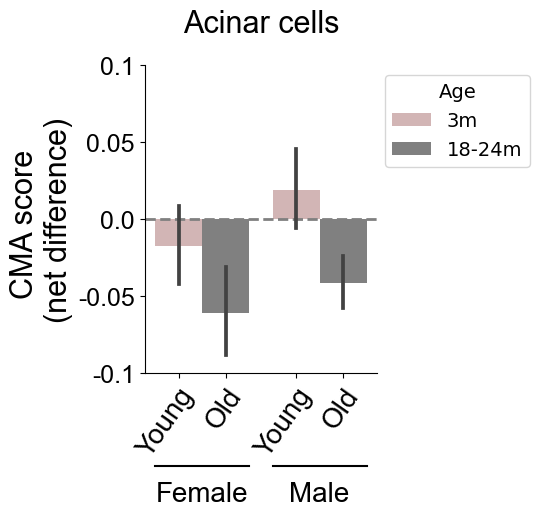

In [11]:
# Figure Acinar
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Acin_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

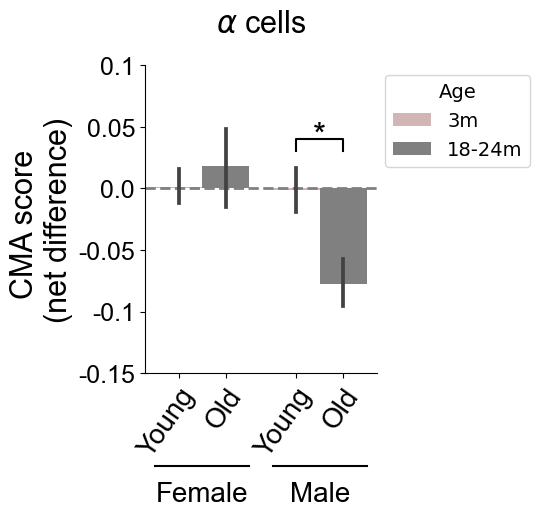

In [12]:
# Figure Alpha cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[1]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/A_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

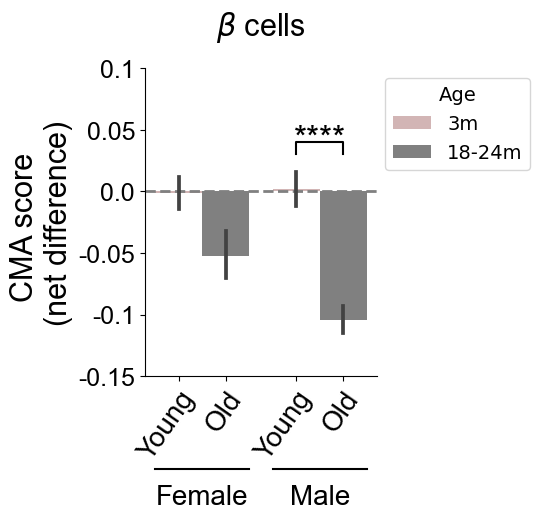

In [13]:
# Figure Beta cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[2]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/B_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [14]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Panc_Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
    
    return(df_raw)

In [15]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,pancreatic acinar cell,3m,female,100,-0.017506,0.025501
1,pancreatic acinar cell,3m,male,91,0.019237,0.025995
2,pancreatic acinar cell,18-24m,female,118,-0.060920,0.029291
3,pancreatic acinar cell,18-24m,male,267,-0.041282,0.016744
4,pancreatic A cell,3m,female,181,0.001462,0.013875
5,pancreatic A cell,3m,male,183,-0.001446,0.017474
6,pancreatic A cell,18-24m,female,41,0.018377,0.031274
7,pancreatic A cell,18-24m,male,116,-0.077723,0.019509
8,type B pancreatic cell,3m,female,281,-0.001450,0.012920
9,type B pancreatic cell,3m,male,241,0.001690,0.014090


## CMA network heatmaps by cell type & sex

In [16]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [18]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Panc_Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap removing GFAP
    if cellpop == cells[1] or cellpop == cells[2]:
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        if cellpop == cells[1]:
            plt.title(r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        elif cellpop == cells[2]:
            plt.title(r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else: # including GFAP
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title('Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + '/{}_heat.png'.format(cellpop[:3]), bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 45.46it/s]


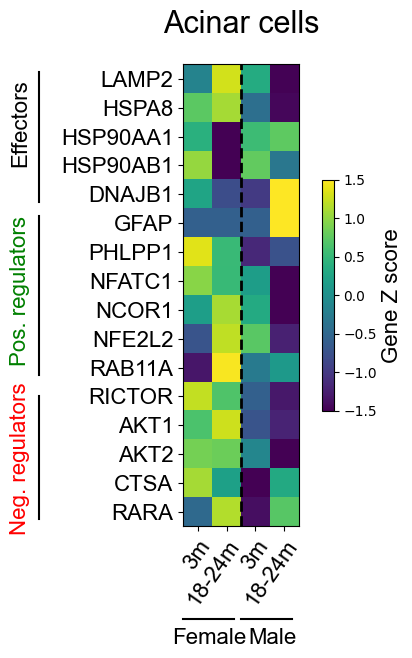

100%|██████████| 16/16 [00:00<00:00, 36.29it/s]


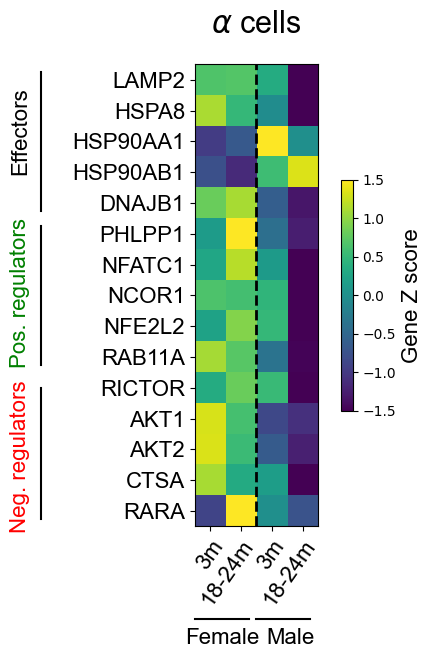

100%|██████████| 16/16 [00:00<00:00, 21.19it/s]


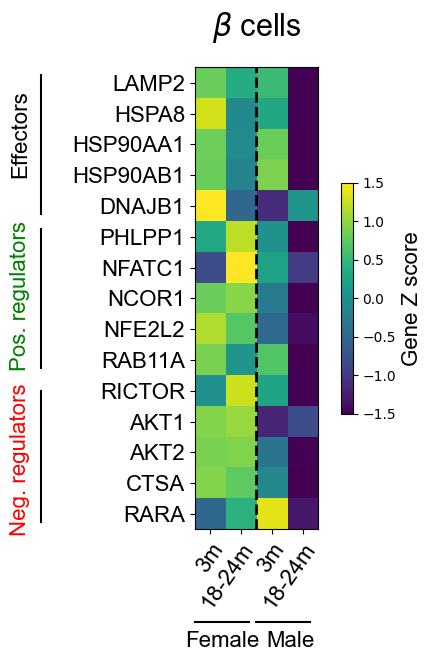

In [19]:
for i in cells:
    sex_heatmaps(cellpop=i)

# Lysosomal genes

In [8]:
# Directories
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx' 

In [12]:
# Reading table with genes
genes = pd.read_excel(modelmx, 'Review_genes') 

In [14]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
notfound = ['ENSMUSG00000035953', 'ENSMUSG00000038295', 'ENSMUSG00000006056', 
            'ENSMUSG00000029104', 'ENSMUSG00000050697', 'ENSMUSG00000028518', 
            'ENSMUSG00000032127', 'ENSMUSG00000053647']

idx_val = genes.loc[genes['Ensembl Ms'].isin(notfound)].index.tolist()

# Removing genes not present
model_matrix = genes.drop(idx_val, axis=0).reset_index(drop=True)

# Finding genes of interest in the dataset
network = adata[:, model_matrix['Ensembl Ms']]

In [15]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(model_matrix['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# reset obs index
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

In [18]:
# Change in cell names
network.obs.cell_type.replace('type B pancreatic cell', 'pancreatic b_cell', inplace=True)
network.obs.cell_type.replace('pancreatic A cell', 'pancreatic a_cell', inplace=True)
cells = ['pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic b_cell']
network.obs.cell_type.unique()

['pancreatic b_cell', 'pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'pancreatic b_cell', 'pancreatic a_cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic PP cell', 'pancreatic stellate cell']

### Lysosome physiology genes

In [16]:
genes = model_matrix[model_matrix['Gene_set']=='Lysosomes']['Symbol'].to_list()
print(genes[:4])
len(genes)

['ASAH1', 'CTSA', 'CTSB', 'CTSD']


54

In [27]:
def lysosomes(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((54, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    df_m.to_excel(output_dir + "Panc{}_raw.xlsx".format(cellpop[11:17]), 
                  sheet_name='Lysosomes', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,14))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(54), genes, fontsize=16, **hfont)

    plt.ylim(53.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'panc{}lysheat.png'.format(cellpop[11:17]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 54/54 [00:00<00:00, 56.17it/s]


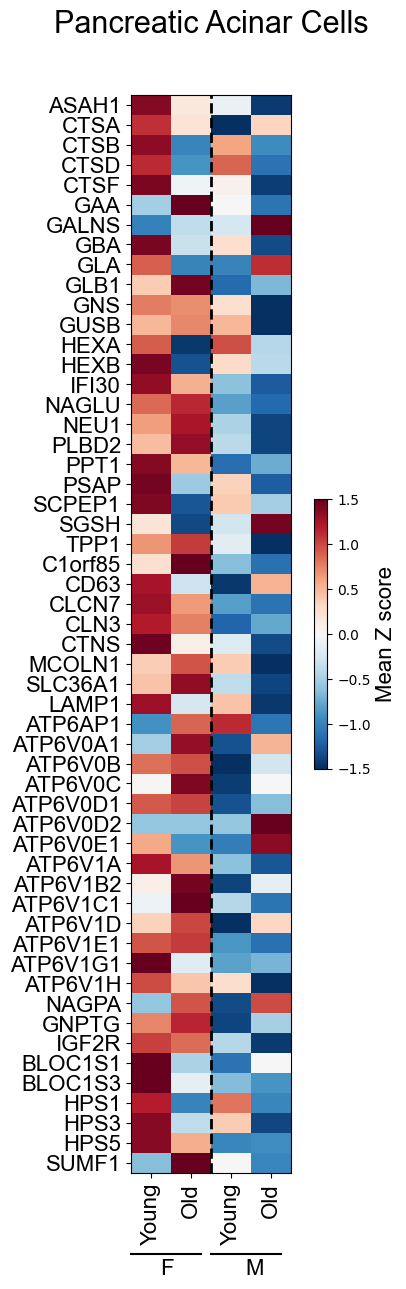

100%|██████████| 54/54 [00:01<00:00, 46.92it/s]


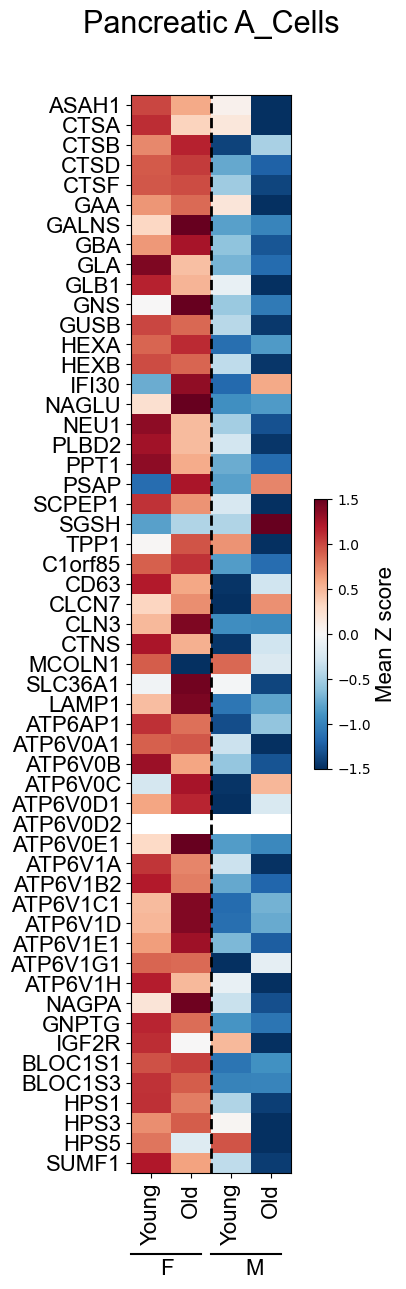

100%|██████████| 54/54 [00:01<00:00, 35.97it/s]


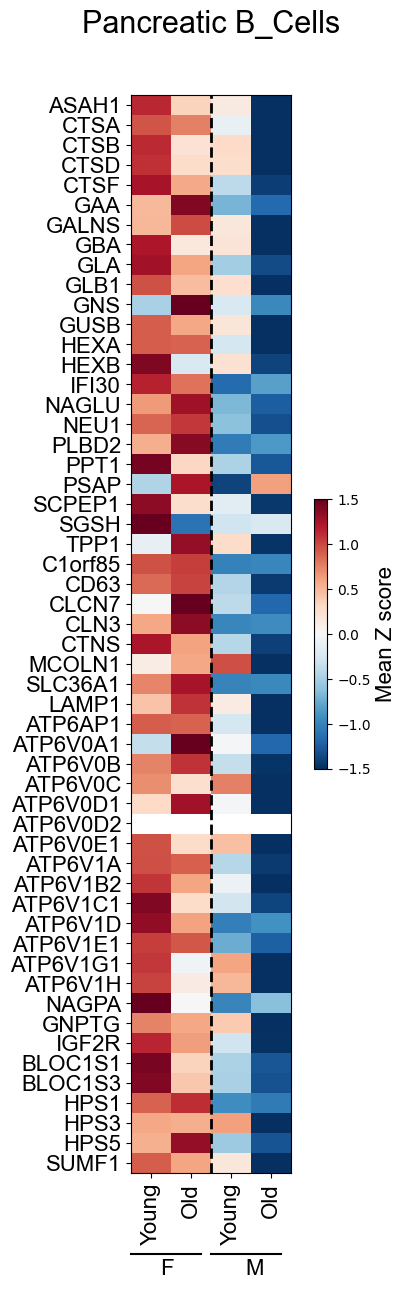

In [28]:
for i in cells:
    lysosomes(cellpop=i)

### Macroautophagy genes

In [29]:
genes = model_matrix[model_matrix['Gene_set']=='Macroautophagy']['Symbol'].to_list()
print(genes[:4])
len(genes)

['AMBRA1', 'ATG3', 'ATG4A', 'ATG4B']


77

In [32]:
# Heatmap for Macro genes
def macro(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((77, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Panc{}_raw.xlsx".format(cellpop[11:17]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Macroautophagy', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,18))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r',  vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(77), genes, fontsize=16, **hfont)

    plt.ylim(76.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'panc{}MAheat.png'.format(cellpop[11:17]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 77/77 [00:01<00:00, 57.04it/s]


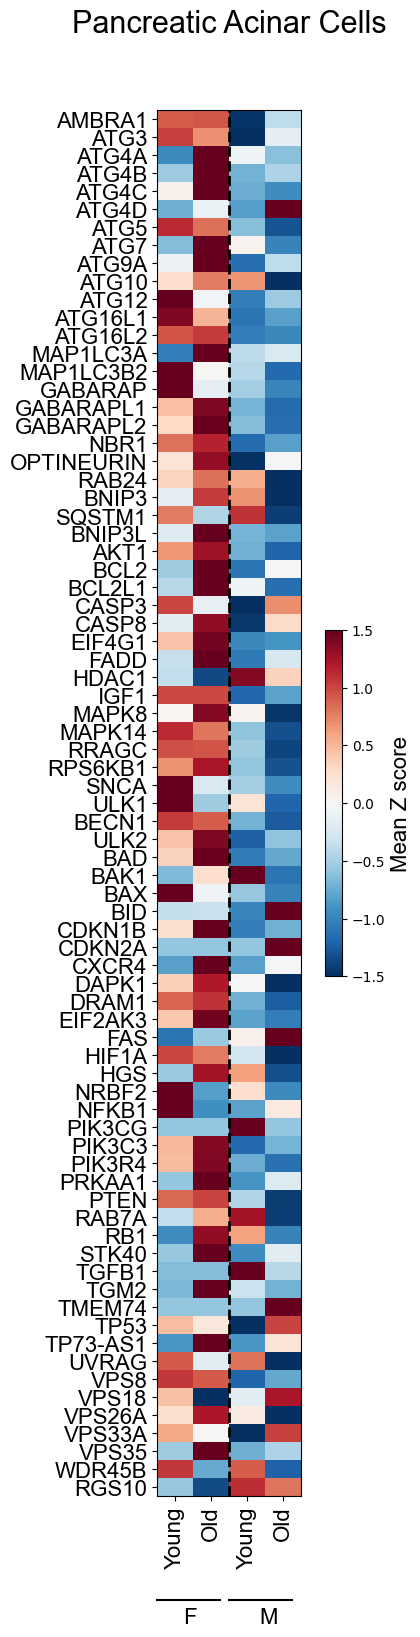

100%|██████████| 77/77 [00:01<00:00, 48.80it/s]


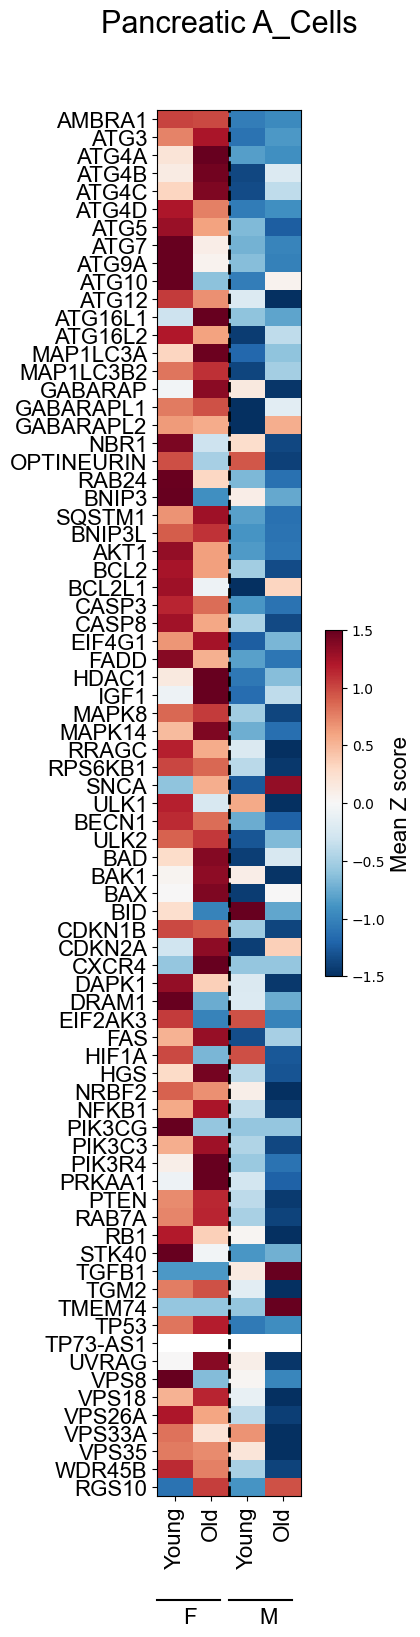

100%|██████████| 77/77 [00:02<00:00, 35.95it/s]


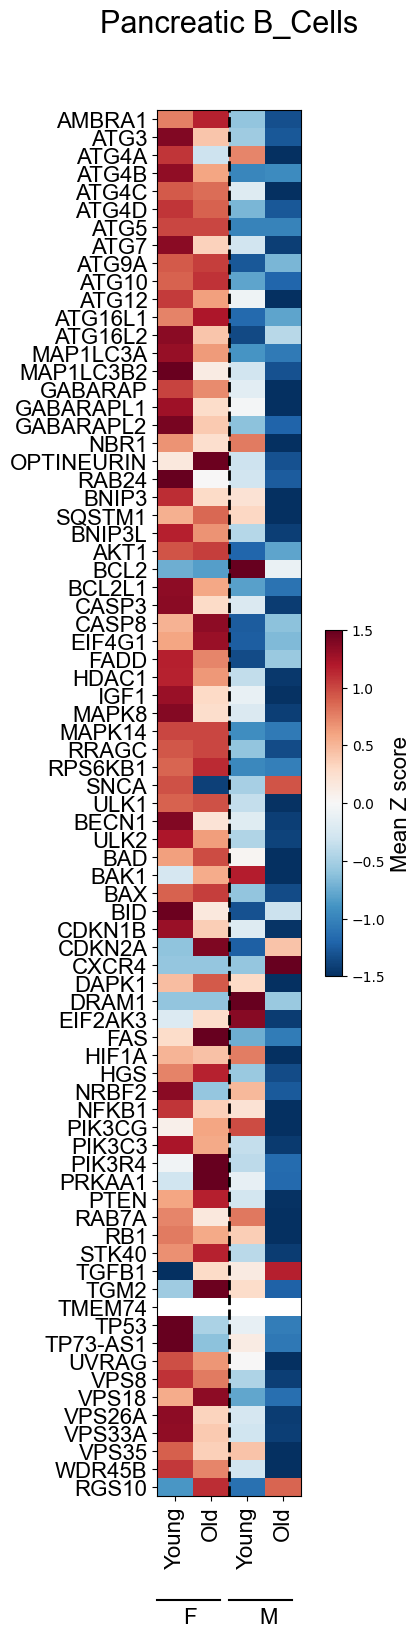

In [33]:
for i in cells:
    macro(cellpop=i)

### Selective MA

In [34]:
genes = model_matrix[model_matrix['Gene_set']=='Selective MA']['Symbol'].to_list()
print(genes[:4])
len(genes)

['Bcl2L13', 'PHB2', 'TAX1BP1', 'PINK']


15

In [35]:
def selective(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((15, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Panc{}_raw.xlsx".format(cellpop[11:17]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Selective MA', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,9))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r')
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(15), genes, fontsize=16, **hfont)

    plt.ylim(14.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'panc{}selMAheat.png'.format(cellpop[11:17]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 15/15 [00:00<00:00, 56.69it/s]


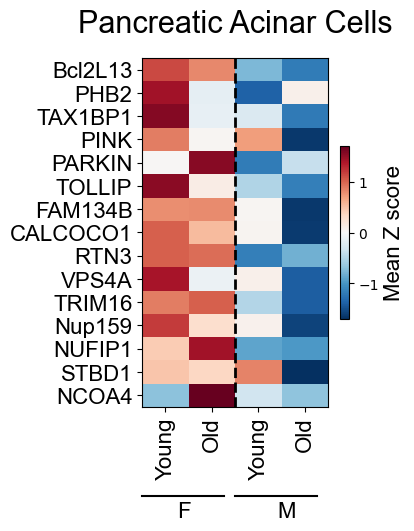

100%|██████████| 15/15 [00:00<00:00, 50.95it/s]


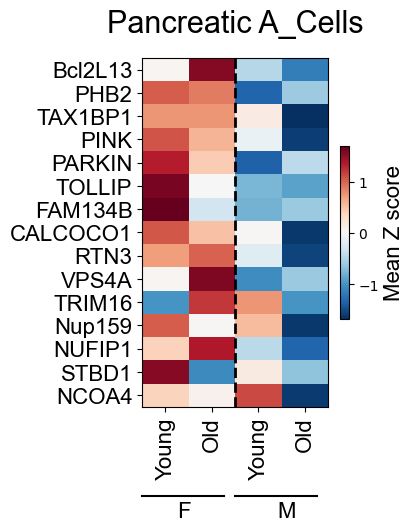

100%|██████████| 15/15 [00:00<00:00, 41.97it/s]


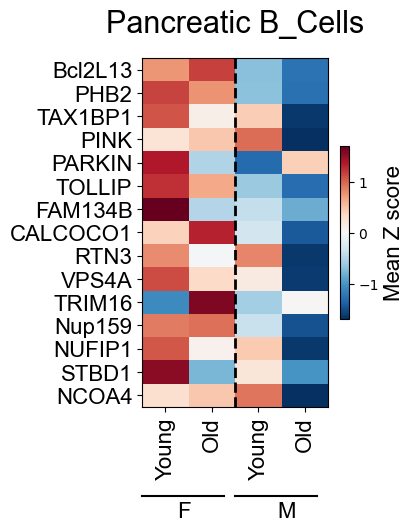

In [36]:
for i in cells:
    selective(cellpop=i)

### Extra lysosomal genes

In [5]:
# Directories
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx' 

In [6]:
# Reading table with genes
modelmx = pd.read_excel(modelmx, 'LysExtra') 
genes = list(modelmx['Symbol'])

In [7]:
# Finding genes of interest in the dataset
network = adata[:, modelmx['Ensembl Ms']]
network.var_names

Index(['ENSMUSG00000023990', 'ENSMUSG00000000134', 'ENSMUSG00000029553'], dtype='object')

In [8]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(modelmx['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# reset obs index
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

In [9]:
# Change in cell names
network.obs.cell_type.replace('type B pancreatic cell', 'pancreatic b_cell', inplace=True)
network.obs.cell_type.replace('pancreatic A cell', 'pancreatic a_cell', inplace=True)
cells = ['pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic b_cell']
network.obs.cell_type.unique()

['pancreatic b_cell', 'pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'pancreatic b_cell', 'pancreatic a_cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic PP cell', 'pancreatic stellate cell']

In [10]:
def selective(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((3, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
        
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Panc{}_raw.xlsx".format(cellpop[11:17]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='LysExtra', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,5))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r')
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(3), genes, fontsize=16, **hfont)

    plt.ylim(2.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.3,1.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.7, 3.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'panc{}lysextraheat.png'.format(cellpop[11:17]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 3/3 [00:00<00:00, 51.58it/s]


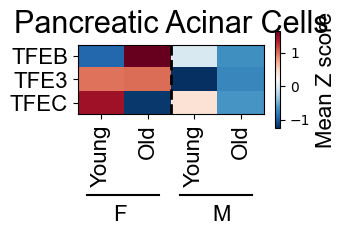

100%|██████████| 3/3 [00:00<00:00, 44.39it/s]


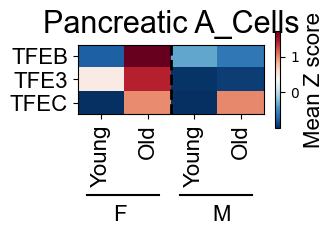

100%|██████████| 3/3 [00:00<00:00, 36.24it/s]


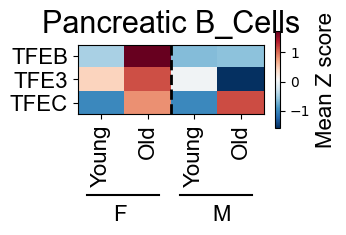

In [11]:
for i in cells:
    selective(cellpop=i)

## Macro score

In [9]:
# Load matrix file with weight and direction 
mamx = pd.read_excel(modelmx, 'Macroautophagy')

# Removing genes not present in the adata
not_found = ['ENSMUSG00000038295', 'ENSMUSG00000006056', 'ENSMUSG00000029104', 
             'ENSMUSG00000050697', 'ENSMUSG00000028518', 'ENSMUSG00000032127']
mamx = mamx.drop(mamx[mamx["Ensembl Ms"].isin(not_found)].index, axis=0).reset_index(drop=True)

# Finding MA network genes in the dataset
ma_network = adata[:, mamx["Ensembl Ms"]]

In [10]:
# Calculating the Zs scores
ma_data_zs = ma_network.copy().X.todense().T

for i in tqdm(np.arange(ma_data_zs.shape[0])):
    
    µ = np.mean(ma_data_zs[i, :])
    sd = np.std(ma_data_zs[i, :])
    
    ma_data_zs[i, :] = (ma_data_zs[i, :] - µ)/sd

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = mamx.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = ma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['direction'] * cell_matrix['weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['weight'])

    barcode.loc[j, 'ma_score'] = score   

barcode.head()
    

100%|██████████| 78/78 [00:00<00:00, 20994.40it/s]
3384it [00:10, 328.88it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,ma_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m,-0.152319,-0.199832,-0.033521
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m,-0.067126,-0.114639,-0.154583
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m,0.117219,0.069706,0.184900
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m,-0.028869,-0.076382,0.282151
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m,-0.778264,-0.351906,-0.497972


In [11]:
# Calculation of ma net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['ma_score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'macell_ns'] = barcode.loc[cell_index, 'ma_score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 43.25it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,ma_score,macell_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m,-0.152319,-0.199832,-0.033521,-0.221979
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m,-0.067126,-0.114639,-0.154583,-0.343041
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m,0.117219,0.069706,0.184900,-0.003559
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m,-0.028869,-0.076382,0.282151,0.093692
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m,-0.778264,-0.351906,-0.497972,-0.158845


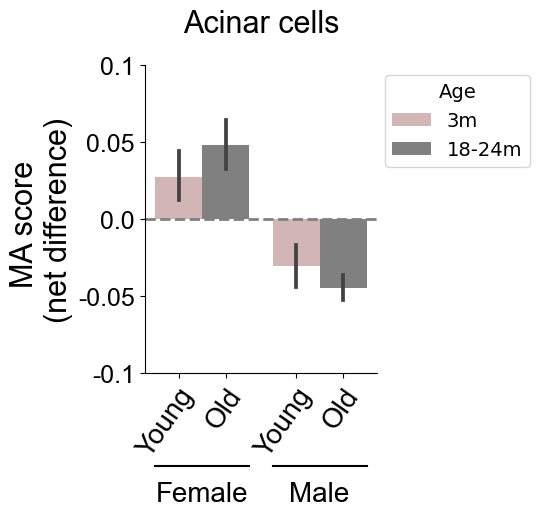

In [46]:
# Figure Acinar
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + 'pancacinarmans.png',bbox_inches='tight', dpi=600)

plt.show()

In [12]:
# Change in cell names
barcode.cell_type.replace('type B pancreatic cell', 'pancreatic b_cell', inplace=True)
barcode.cell_type.replace('pancreatic A cell', 'pancreatic a_cell', inplace=True)
barcode.cell_type.unique()

['pancreatic b_cell', 'pancreatic acinar cell', 'pancreatic a_cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'pancreatic b_cell', 'pancreatic a_cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic PP cell', 'pancreatic stellate cell']

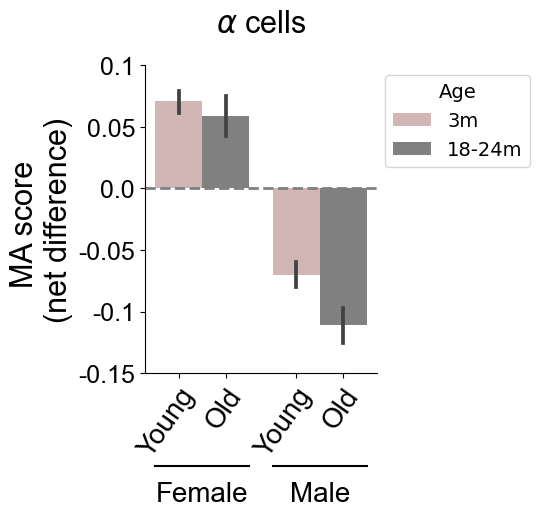

In [49]:
# Figure Alpha cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type==cells[1]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + 'panca_cellmans.png',bbox_inches='tight', dpi=600)

plt.show()

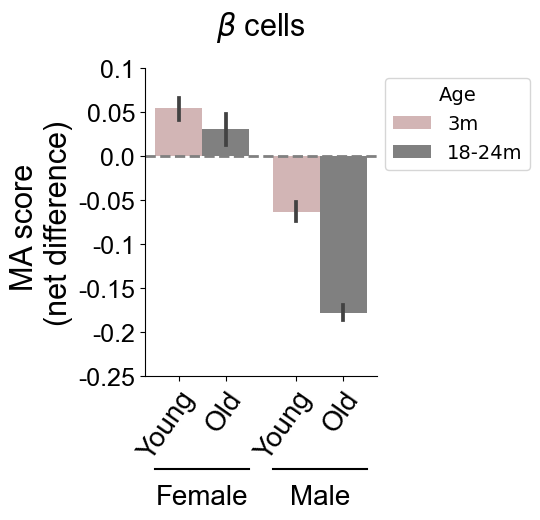

In [51]:
# Figure Beta cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type==cells[2]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.10)
ax.set_yticks([-0.25, -0.2, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.25, -0.2, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + 'pancb_cellmans.png',bbox_inches='tight', dpi=600)

plt.show()

In [54]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad=['3m', '18-24m'], sex=['female', 'male']):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for x in edad:
        for y in sex:
            n = len(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y].index)
            m = np.mean(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])
            s = stats.sem(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])

            long.append(n)
            celula.append(tipos)                
            age.append(x)
            sexo.append(y)
            mean.append(m)
            sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter(output_dir + "/Panc{}_raw.xlsx".format(tipos[11:17]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_raw.to_excel(writer, sheet_name='MA score', index=True)

    print(df_raw)

In [55]:
for i in cells:
    raw(tipos = i)

                Cell_type     Age     Sex    n      Mean       SEM
0  pancreatic acinar cell      3m  female  100  0.027524  0.016085
1  pancreatic acinar cell      3m    male   91 -0.030246  0.014076
2  pancreatic acinar cell  18-24m  female  118  0.048235  0.015743
3  pancreatic acinar cell  18-24m    male  267 -0.044749  0.007967
           Cell_type     Age     Sex    n      Mean       SEM
0  pancreatic a_cell      3m  female  181  0.070763  0.009298
1  pancreatic a_cell      3m    male  183 -0.069990  0.010107
2  pancreatic a_cell  18-24m  female   41  0.059166  0.016190
3  pancreatic a_cell  18-24m    male  116 -0.110757  0.014450
           Cell_type     Age     Sex    n      Mean       SEM
0  pancreatic b_cell      3m  female  281  0.054210  0.012461
1  pancreatic b_cell      3m    male  241 -0.063207  0.011008
2  pancreatic b_cell  18-24m  female  142  0.030564  0.017410
3  pancreatic b_cell  18-24m    male  678 -0.177717  0.008657


## Correlation with hormone receptors

In [13]:
# Reading df for hormone receptors
horm = pd.read_excel(r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx', 'Review_genes')
horm_symbol = horm[horm['Gene_set']=='Hormones']['Symbol'].to_list()
horm_ensembl = horm[horm['Gene_set']=='Hormones']['Ensembl Ms'].to_list()

In [14]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
horm_symbol = [i for i in horm_symbol if i != 'GPER1']
horm_ensembl = [i for i in horm_ensembl if i != 'ENSMUSG00000053647']

# Finding genes of interest in the dataset
hormdf = adata[:, horm_ensembl]
hormdf.layers["scaled"] = sc.pp.scale(hormdf, copy=True).X
hormdf

AnnData object with n_obs × n_vars = 3384 × 6
    obs: 'FACS.selection', 'age', 'cell', 'free_annotation', 'method', 'donor_id', 'subtissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'age_colors', 'citation', 'leiden', 'louvain', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'

In [15]:
# Dataframe with Hormone Zs values
hormzs = pd.DataFrame(hormdf.layers['scaled'], columns = horm_symbol, index=hormdf.obs.index)
hormzs.head()

,ESR1,ESR2,ANDR,PRGR,XIST,LAMP2
index,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,0.845664
A11_B000756_B007446_S11.mm10-plus-0-0,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,-1.404234
A12_B000756_B007446_S12.mm10-plus-0-0,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,0.872309
A13_B000756_B007446_S13.mm10-plus-0-0,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,0.831091
A13_B002832_B007443_S13.mm10-plus-0-0,-0.111538,-0.024304,-0.104933,-0.077997,1.880004,-1.404234


In [16]:
# Merging Barcode and Hormonze Z values dataframe
barcode = pd.merge(barcode, hormzs, how='inner', on='index')
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,net_score,celltype_ns,ma_score,macell_ns,ESR1,ESR2,ANDR,PRGR,XIST,LAMP2
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,-0.152319,-0.199832,-0.033521,-0.221979,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,0.845664
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,-0.067126,-0.114639,-0.154583,-0.343041,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,-1.404234
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,0.117219,0.069706,0.184900,-0.003559,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,0.872309
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,-0.028869,-0.076382,0.282151,0.093692,-0.111538,-0.024304,-0.104933,-0.077997,-0.632257,0.831091
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,-0.778264,-0.351906,-0.497972,-0.158845,-0.111538,-0.024304,-0.104933,-0.077997,1.880004,-1.404234


In [17]:
def hormones (cellpop):
    for horm in horm_symbol:
        if horm == 'LAMP2':
            break
                
        # Dataframe for non-zero hormone values
        filt = barcode[barcode.cell_type==cellpop]
        filt = filt[filt[horm] > np.min(filt[horm])]

        # Saving raw data
        df = filt[['cell_type', 'sex', 'new_age', 'celltype_ns', horm]]
        with pd.ExcelWriter(output_dir + "Panc{}_raw.xlsx".format(cellpop[11:17]),
                            mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
            df.to_excel(writer, sheet_name='{}_corr'.format(horm), index=True)
        
        # Figure
        plot = sns.lmplot(filt, x="celltype_ns", y=horm, hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['3m', '18-24m'], legend_out = True)
        titles = ['Young', 'Old']
        for ax, title in zip(plot.axes.flat, titles):
            ax.set_title(title, fontsize=16)
        plot.set_axis_labels("CMA Net Score", "{} Z-score".format(horm), fontsize=14)

        for ax in plot.axes.flat:
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

        new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
        for t, l in zip(plot._legend.texts, new_labels):
            t.set_text(l)
        plt.setp(plot._legend.get_title(), fontsize=14)  
        plt.setp(plot._legend.get_texts(), fontsize=12)
        plot._legend.set_title('Sex')

        plt.savefig(output_dir + '/panc{}{}.png'.format(cellpop[11:17], horm),bbox_inches='tight', dpi=600)

        plt.show()

        if horm == 'XIST':
            filt2 = filt[filt['LAMP2'] > np.min(filt['LAMP2'])]
            # Saving raw data
            df = filt2[['cell_type', 'sex', 'new_age', 'celltype_ns', horm, 'LAMP2']]
            with pd.ExcelWriter(output_dir + "Panc{}_raw.xlsx".format(cellpop[11:17]),
                                mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
                df.to_excel(writer, sheet_name='{}-L2_corr'.format(horm), index=True)
            
            # XIST-LAMP2 correlation
            plot = sns.lmplot(data=filt2, x="XIST", y="LAMP2", hue='sex',
                              hue_order = ("female", "male"),
                              col='new_age', col_wrap=2, col_order=['3m', '18-24m'], 
                              legend_out = True)
            titles = ['Young', 'Old']
            for ax, title in zip(plot.axes.flat, titles):
                ax.set_title(title, fontsize=16)
            plot.set_axis_labels("XIST Z-score", "LAMP2 Z-score", fontsize=14)

            for ax in plot.axes.flat:
                ax.tick_params(axis='x', labelsize=12)
                ax.tick_params(axis='y', labelsize=12)

            new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
            for t, l in zip(plot._legend.texts, new_labels):
                t.set_text(l)
            plt.setp(plot._legend.get_title(), fontsize=14)  
            plt.setp(plot._legend.get_texts(), fontsize=12)
            plot._legend.set_title('Sex')  # Nuevos labels para la leyenda

            plt.savefig(output_dir + '/panc{}xisl2.png'.format(cellpop[11:17]),bbox_inches='tight', dpi=600)

            plt.show()
    print('Loop finished')

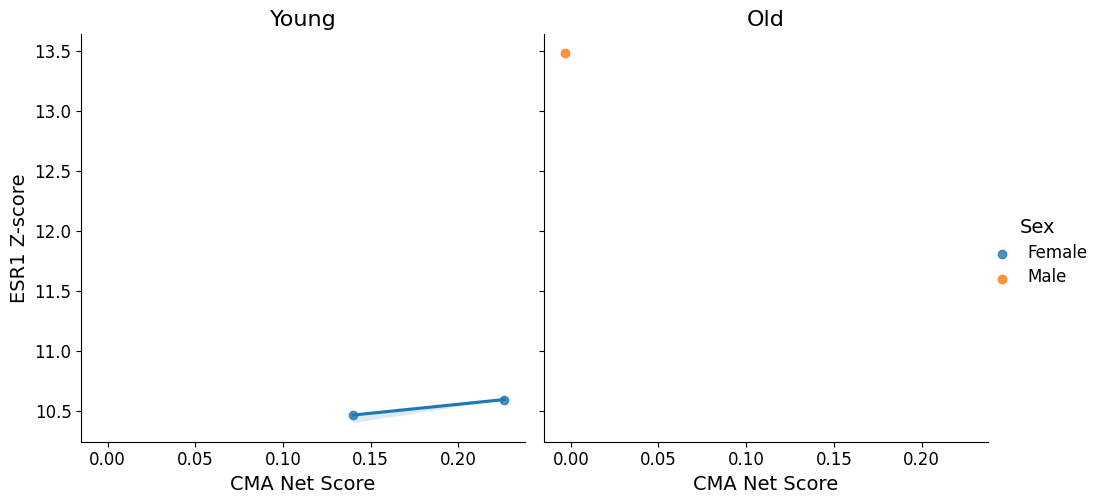

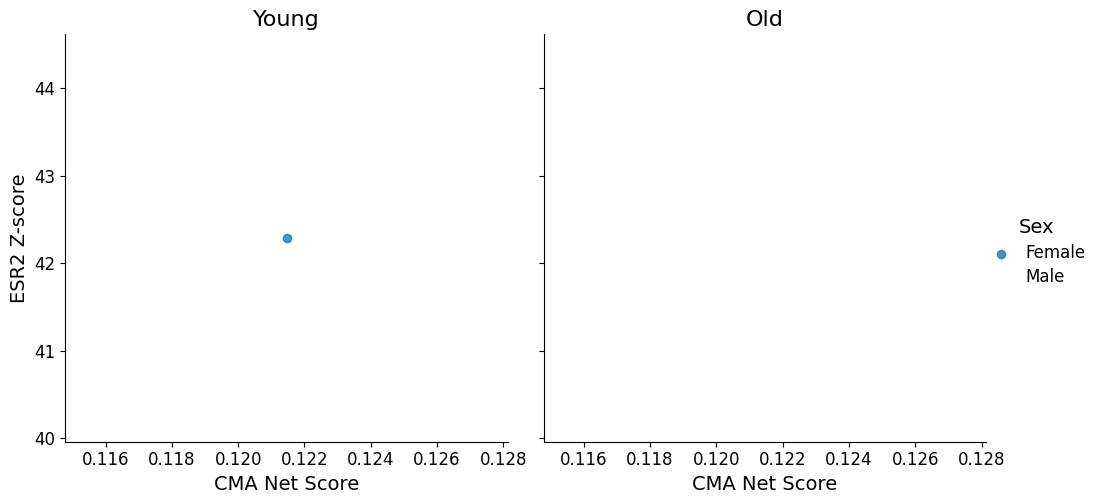

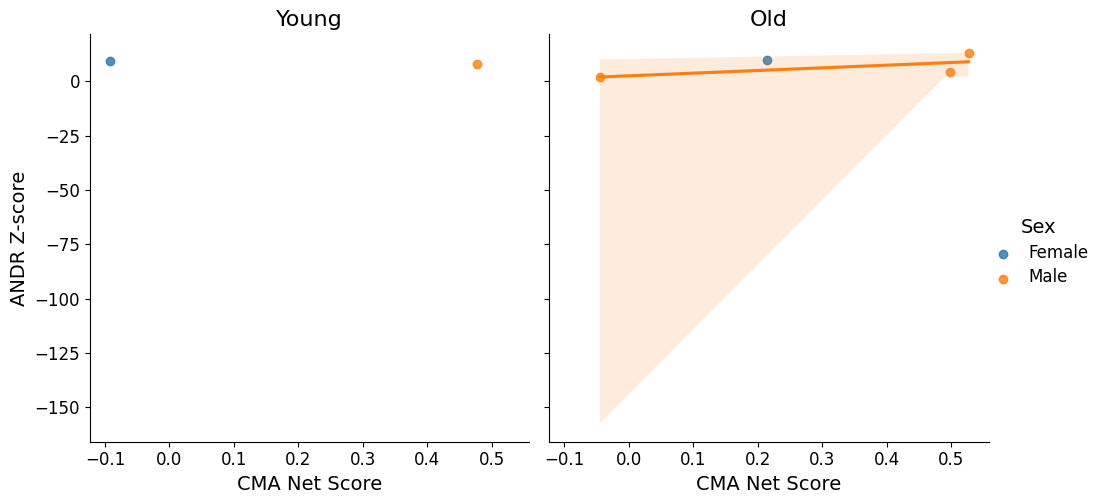

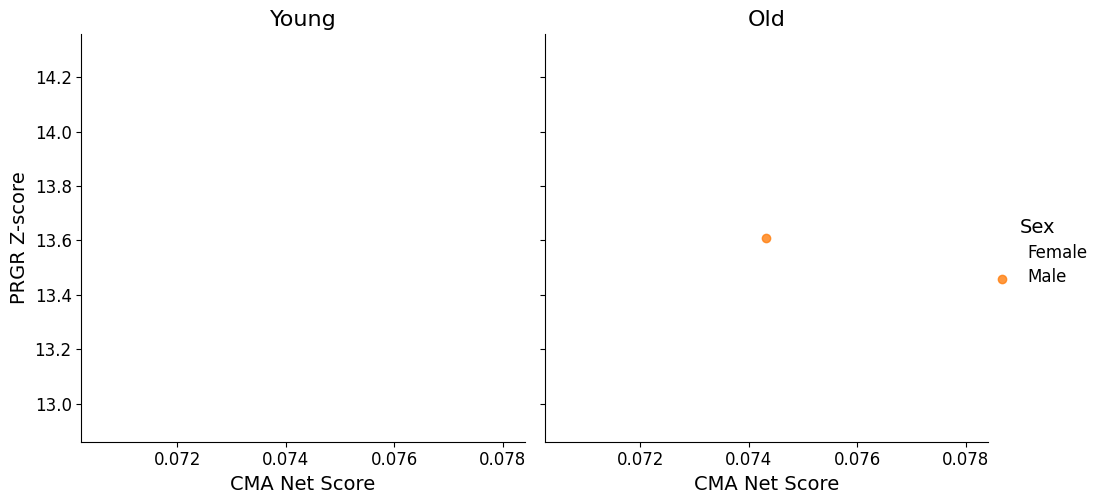

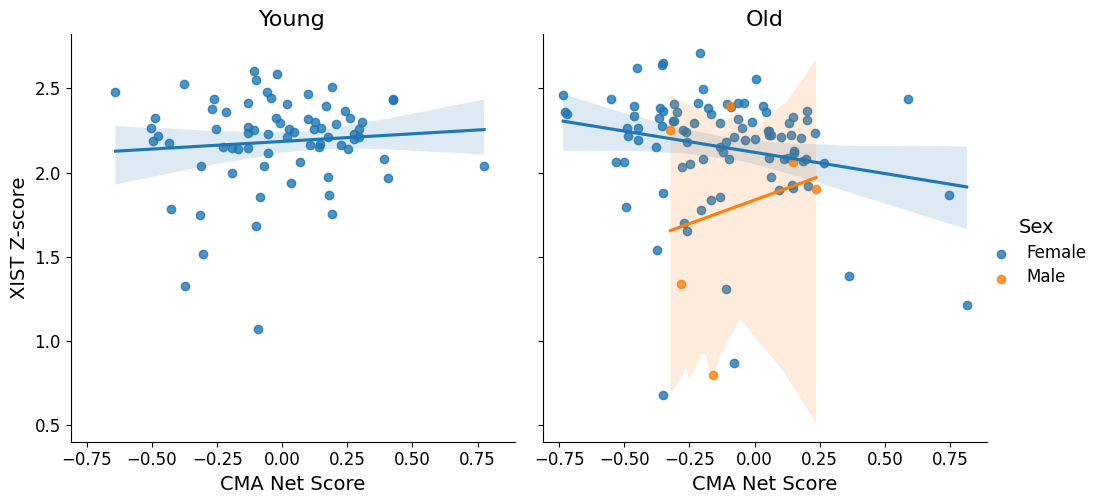

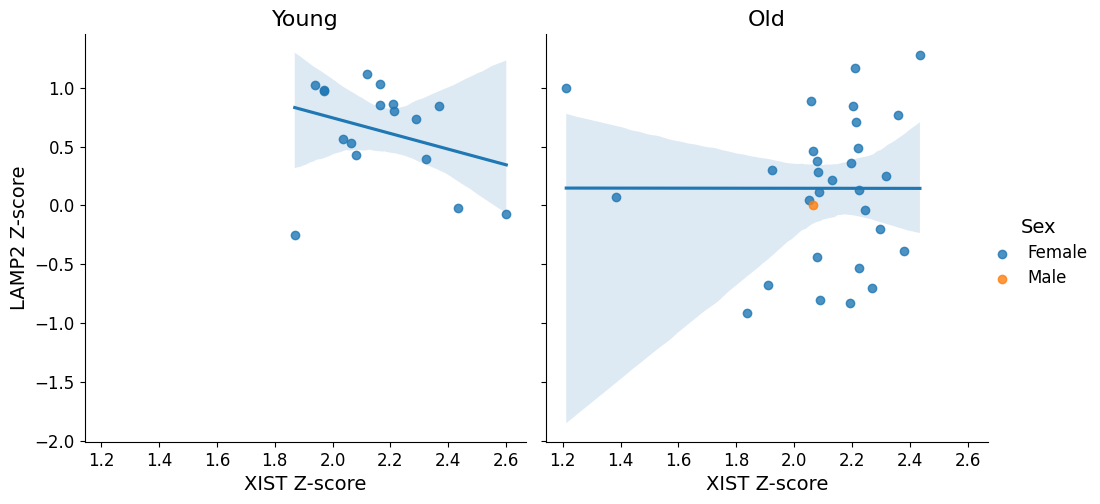

Loop finished


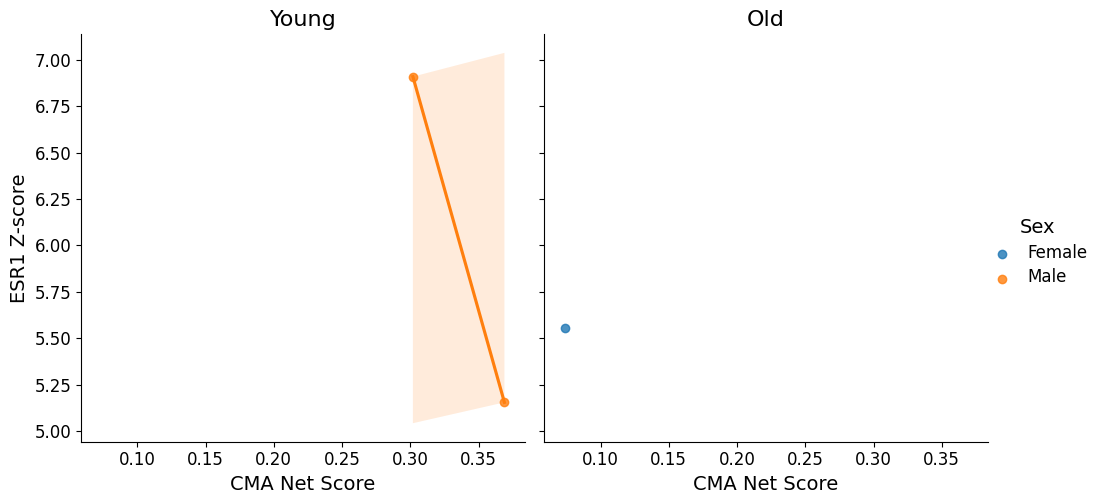

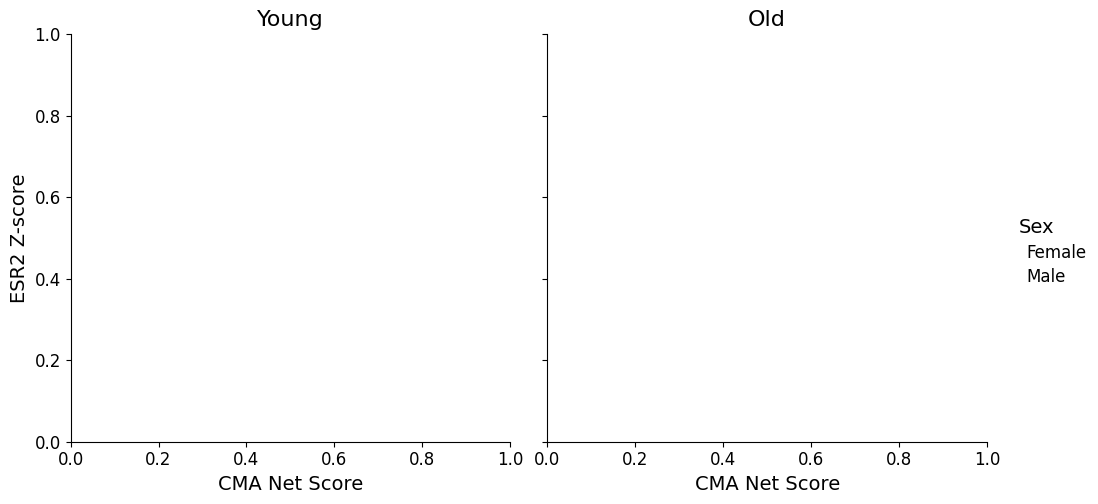

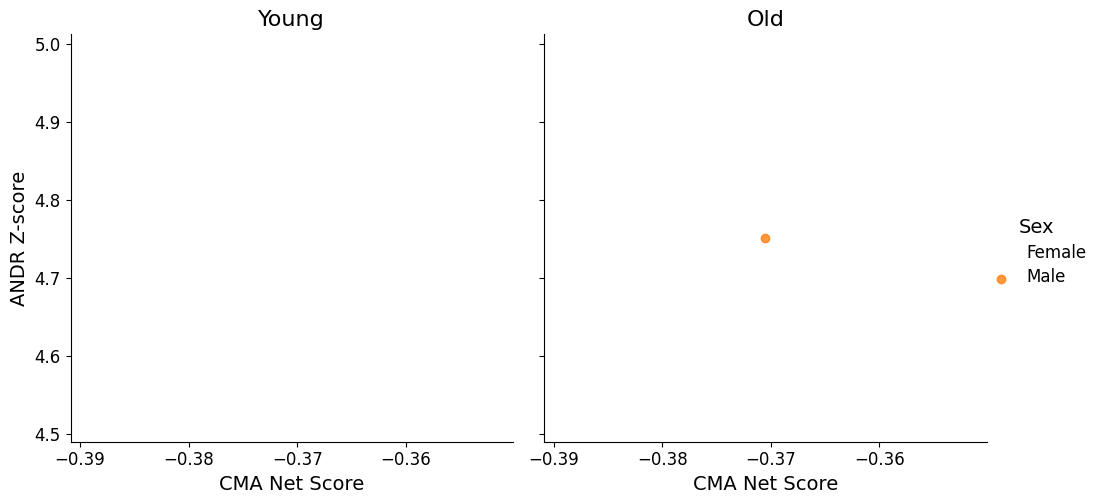

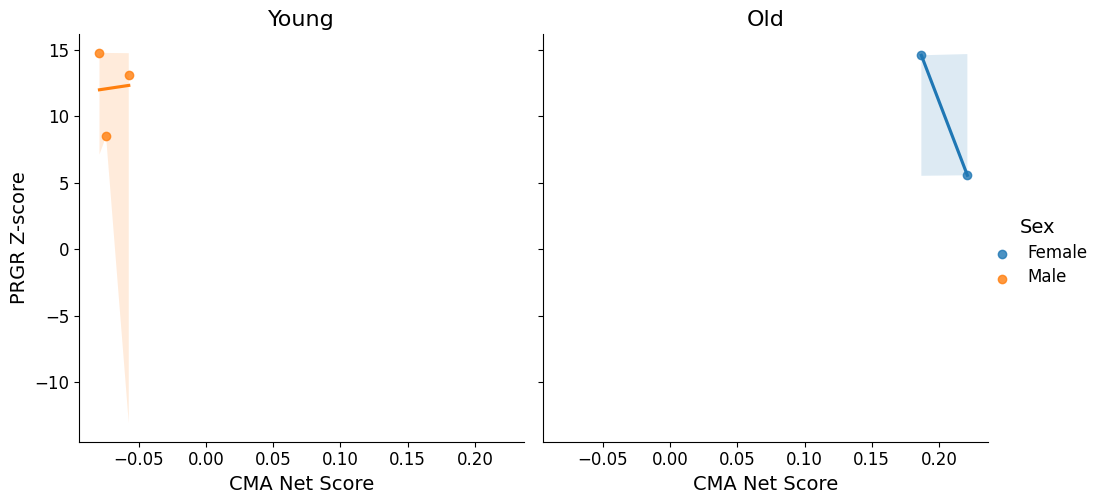

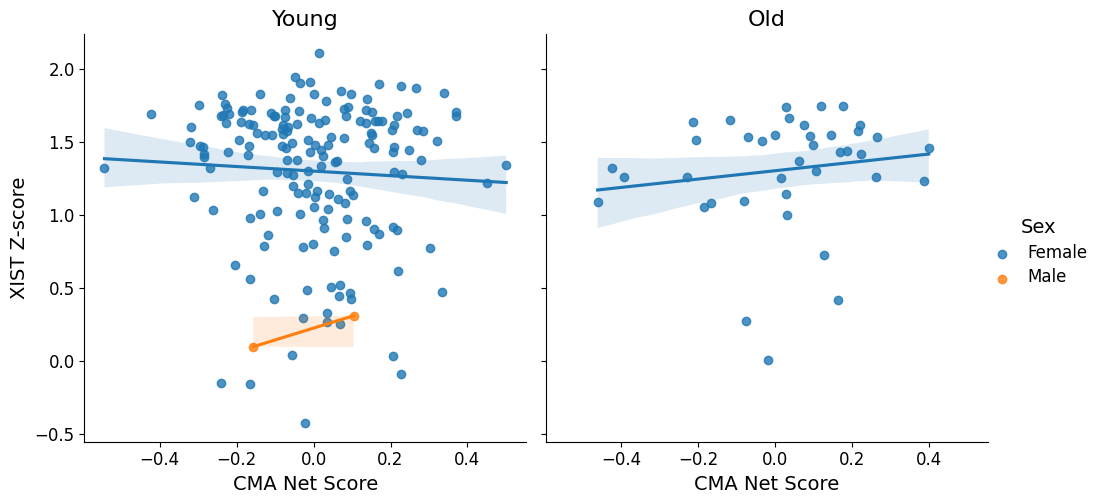

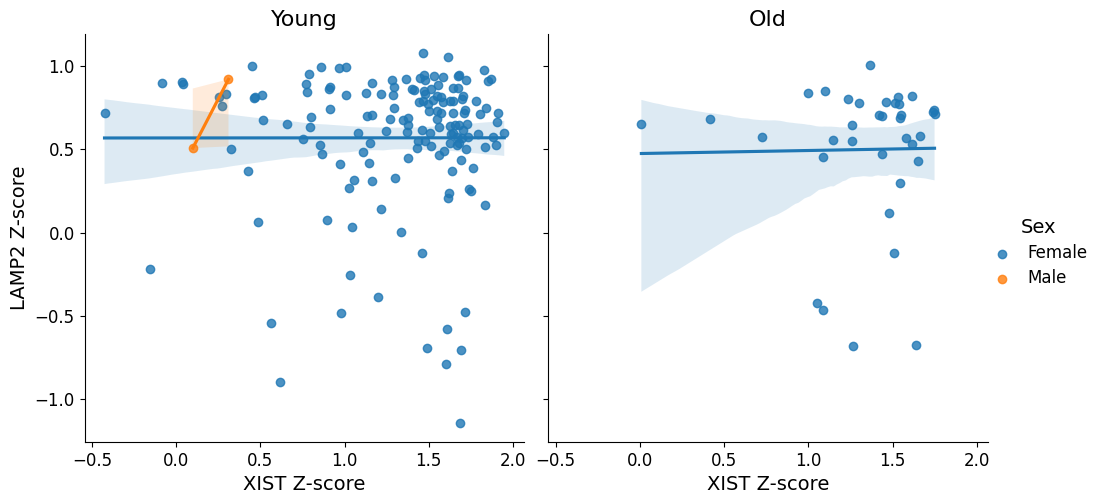

Loop finished


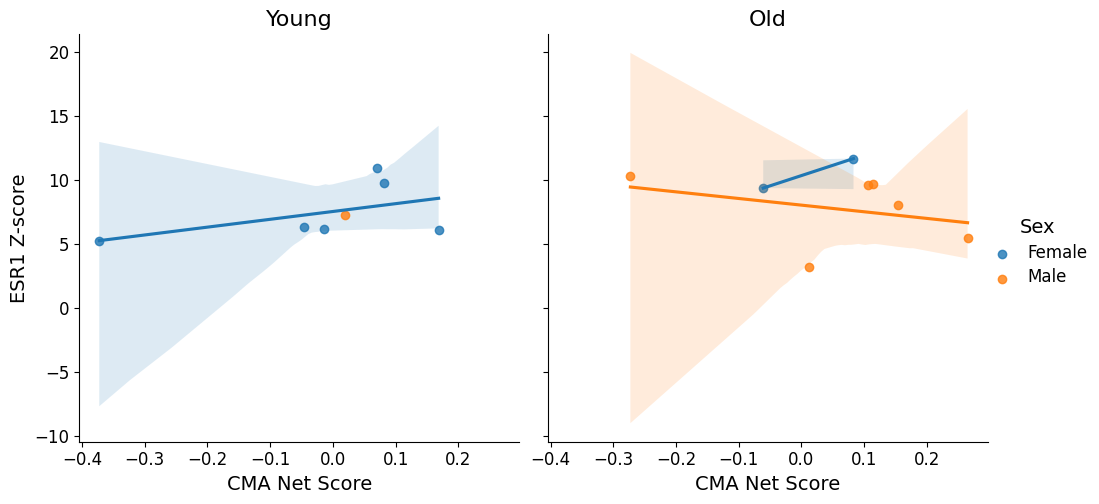

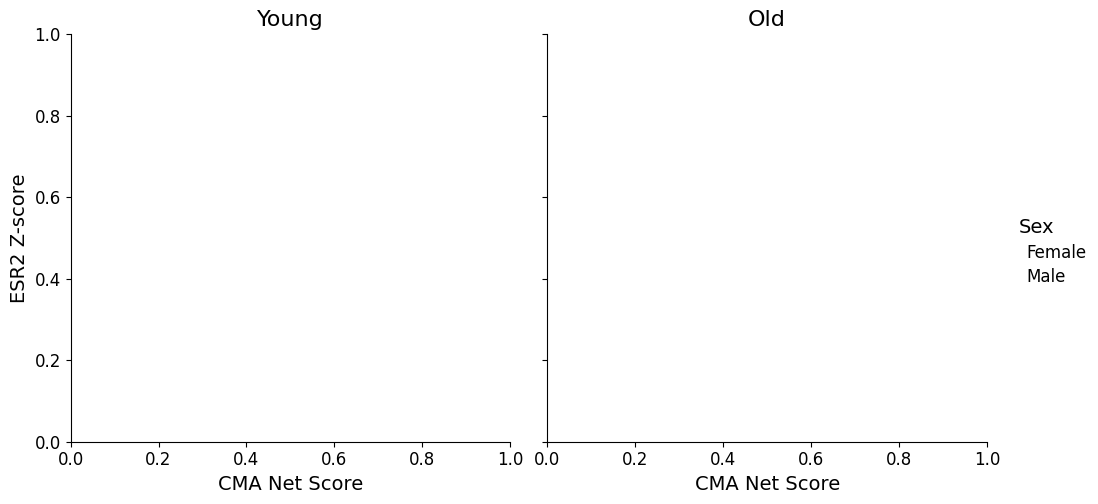

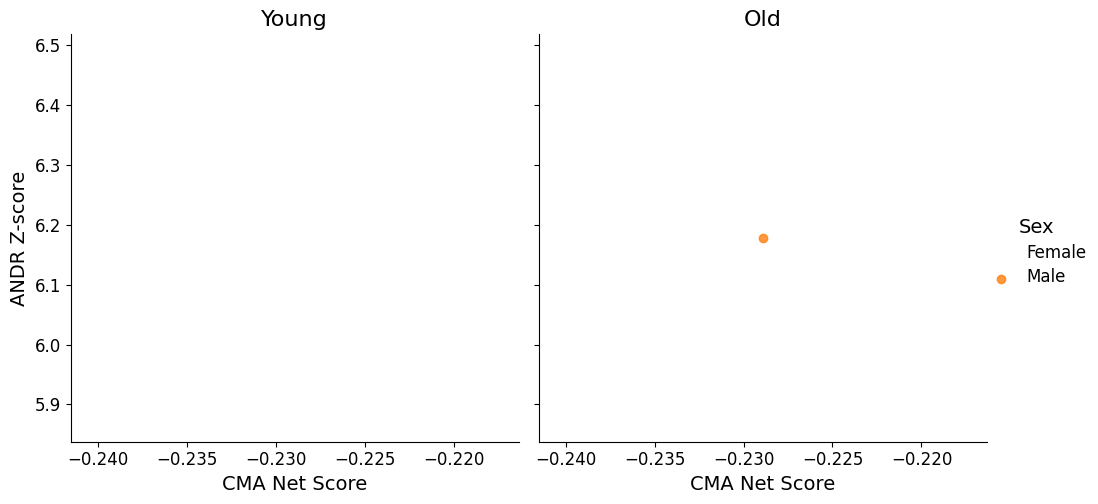

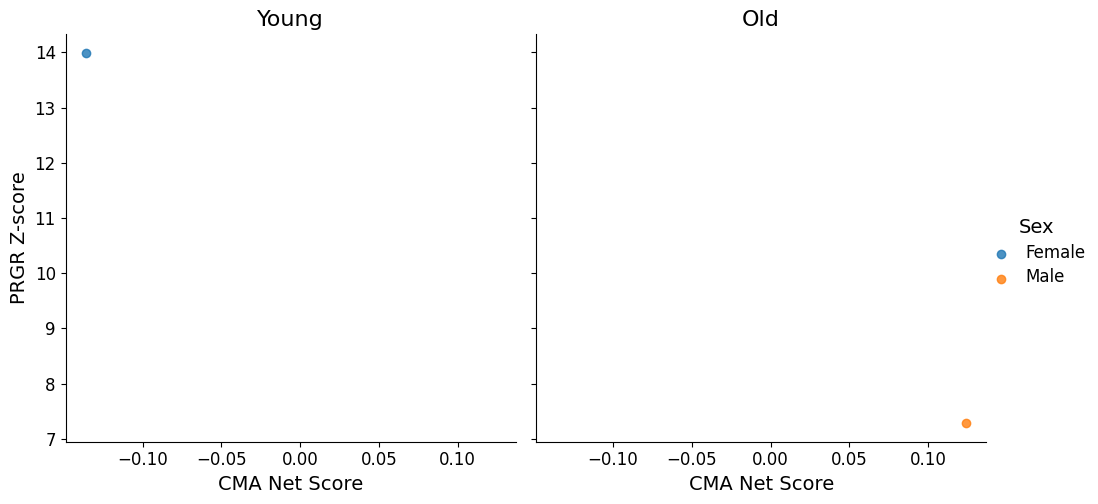

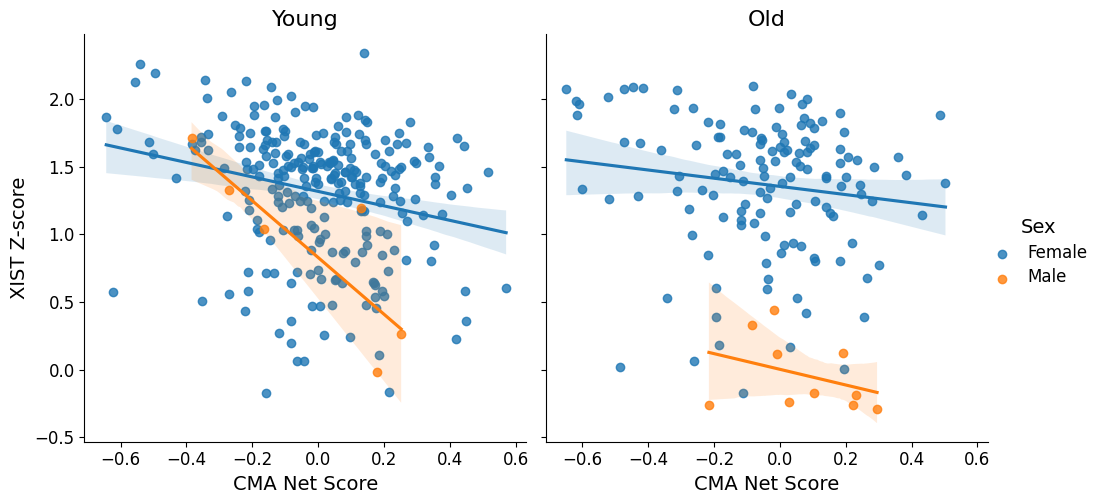

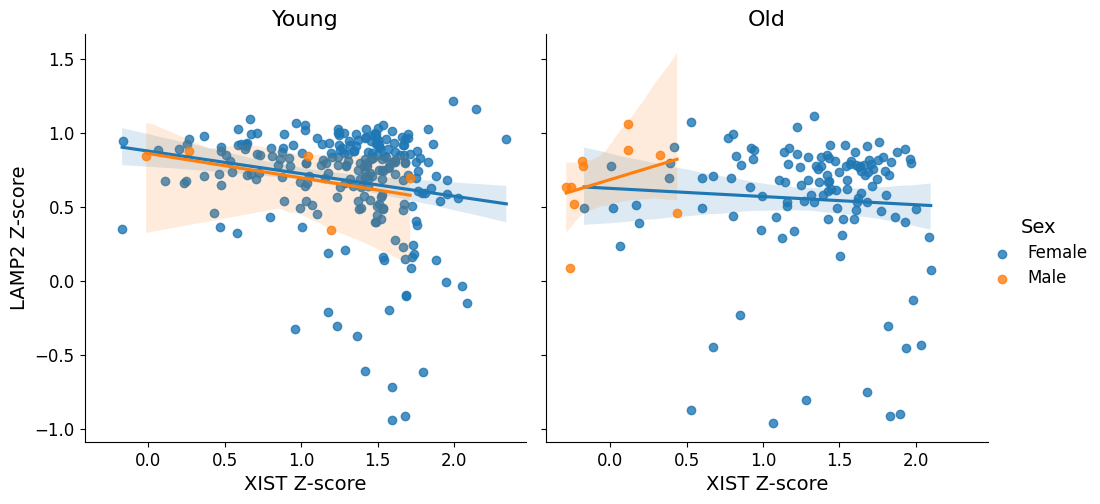

Loop finished


In [20]:
for i in cells:
    hormones(cellpop=i)

## USEFUL BUT NOT USED CODE BELOW THIS LINE
#####################################################################################


In [78]:
filt = barcode[barcode.cell_type=='pancreatic acinar cell']
#filt = filt[filt['ESR1'] > np.min(filt.ESR1)]
filt.shape

(576, 43)

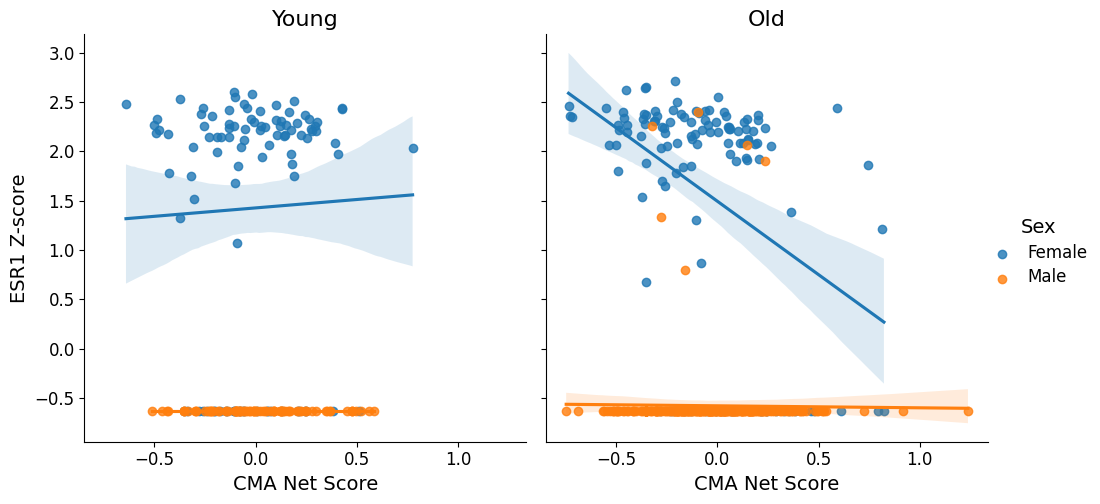

In [79]:
# Correlation removing 0 values
plot = sns.lmplot(filt, x="celltype_ns", y="XIST", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['3m', '18-24m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("CMA Net Score", "ESR1 Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.show()